# Amazon: 20 years of reviews

In [380]:
import pickle
import pandas as pd
import numpy as np
import fastparquet
import matplotlib.pyplot as plt
%matplotlib inline

from afinn import Afinn

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
# IMPORTANT! I cleaned up the parquet directory and uploaded the new version here:
# https://drive.google.com/open?id=1CkC4OMzkUiwjt7un_K6jhMlBVD1L4t5o
# please download it and extract to the right directory. You can delete old parquet files.
PARQUET_DIR = '../parquet/'
TXT_PARQUET_DIR = '../text_parquet/'

In [ ]:
#US reviews by category
with open('category_reviews.pickle', 'rb') as file:
    category_reviews = pickle.load(file)

In [ ]:
reviews = category_reviews[['category']]
reviews.head()

In [ ]:
def parquet_filename(category):
    """
    Returns the filename of parquet corresponding to the given caterogy.
    """
    return PARQUET_DIR + category + '.parquet.gzip'

# Use this function to load data!
def read_DataFrame(category):
    """
    Returns DataFrame corresponding to given category
    """
    return pd.read_parquet(parquet_filename(category))

In [24]:
txt_read_DataFrame('PC').head()

,review_id,review_headline,review_body
0,R3ARRMDEGED8RD,Pleasantly surprised,I was very surprised at the high quality of th...
1,RQ28TSA020Y6J,OnHub is a pretty no nonsense type router that...,I am a Google employee and had to chance to us...
2,RUXJRZCT6953M,None of them worked. No functionality at all.,"Bought cables in 3ft, 6ft and 9ft. NONE of th..."
3,R7EO0UO6BPB71,just keep searching.,"nope, cheap and slow"
4,R39NJY2YJ1JFSV,Five Stars,Excellent! Great value and does the job.


## Explore categories

Let's check what category has the most reviews.

In [12]:
def review_count(category):
    """
    Count all reviews
    """
    return read_DataFrame(category).shape[0]

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


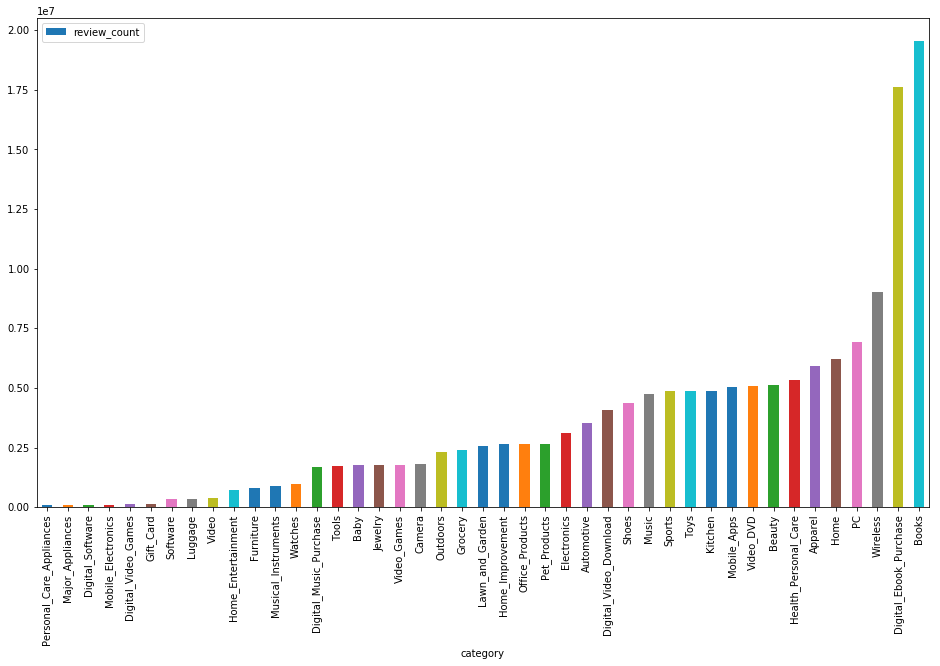

In [13]:
reviews['review_count'] = reviews['category'].apply(review_count)
reviews.sort_values("review_count").plot.bar(x='category', y='review_count', figsize=(16,9))

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


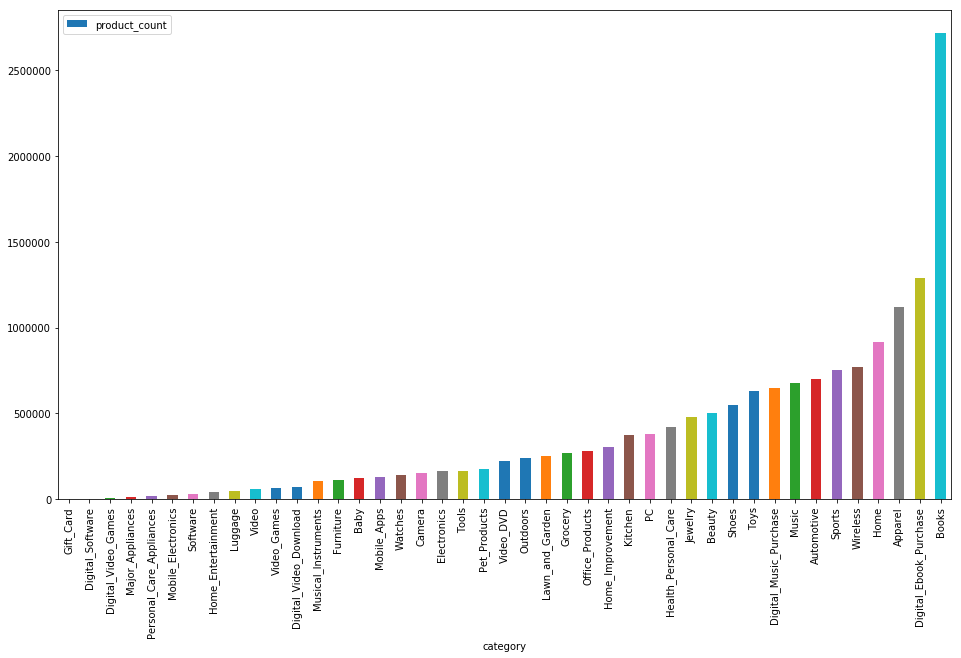

In [14]:
def product_count(category):
    """
    Count unique products
    """
    return read_DataFrame(category).product_parent.nunique()

reviews['product_count'] = reviews['category'].apply(product_count)
reviews.sort_values("product_count").plot.bar(x='category', y='product_count', figsize=(16,9))

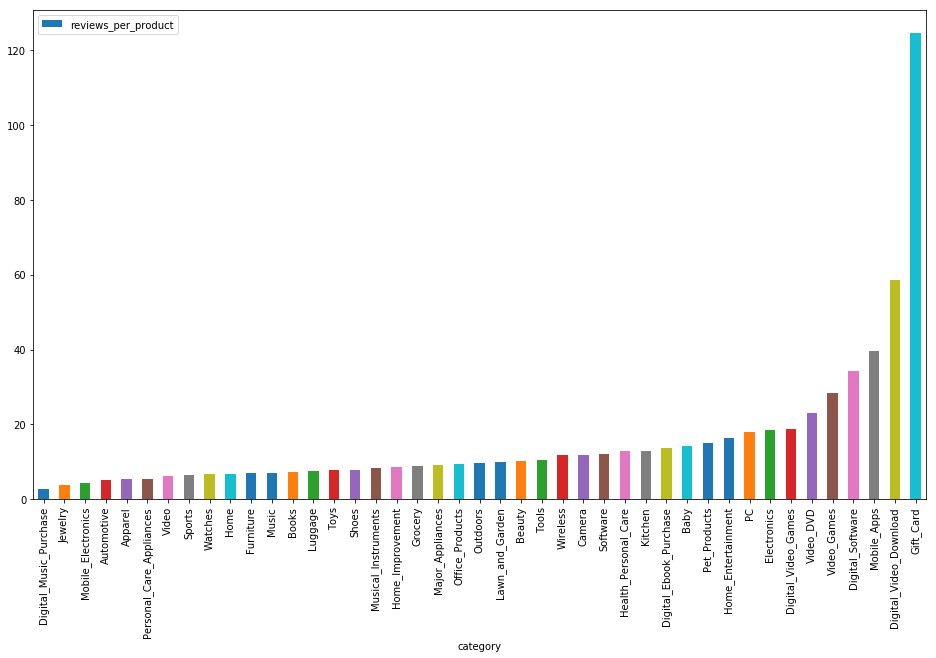

In [16]:
# How many reviews per product in average
reviews['reviews_per_product'] = reviews['review_count']/reviews['product_count']
reviews.sort_values('reviews_per_product').plot.bar(x='category', y='reviews_per_product', figsize=(16,9))

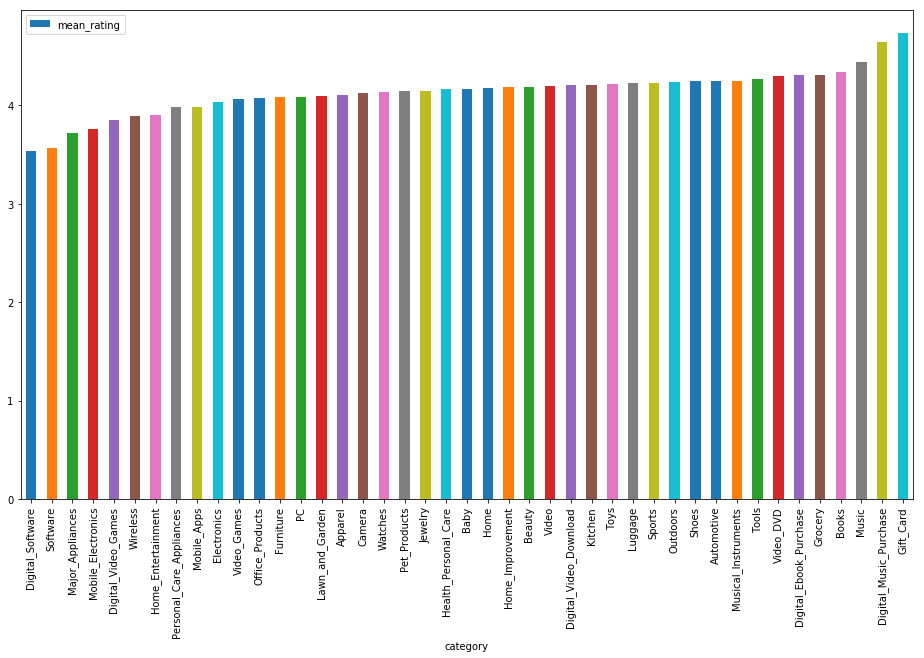

In [17]:
def mean_rating(category):
    """
    Return mean star rating of a category
    """
    return read_DataFrame(category).star_rating.mean()

reviews['mean_rating'] = reviews['category'].apply(mean_rating)
reviews.sort_values('mean_rating').plot.bar(x='category', y='mean_rating', figsize=(16,9))

At first sight, we can see that softwares are more subjected to contreverse regarding the ratings whereas music and books receive in general better grades.
Indeed, categories such as books may be biased in terms of reviews as the buyer is already interested in buying a book which is supposed to interest him. On the contrary, people buyin software or electronic devices may be more disappointed, hence handing out lower ratings.

*Hm, I am not convinced by this explanation. There are not many reviews and products in Software categories, maybe the stats are not reliable? - PJ*


This hypothese can help us in chosing a category to investigate review's reliability.

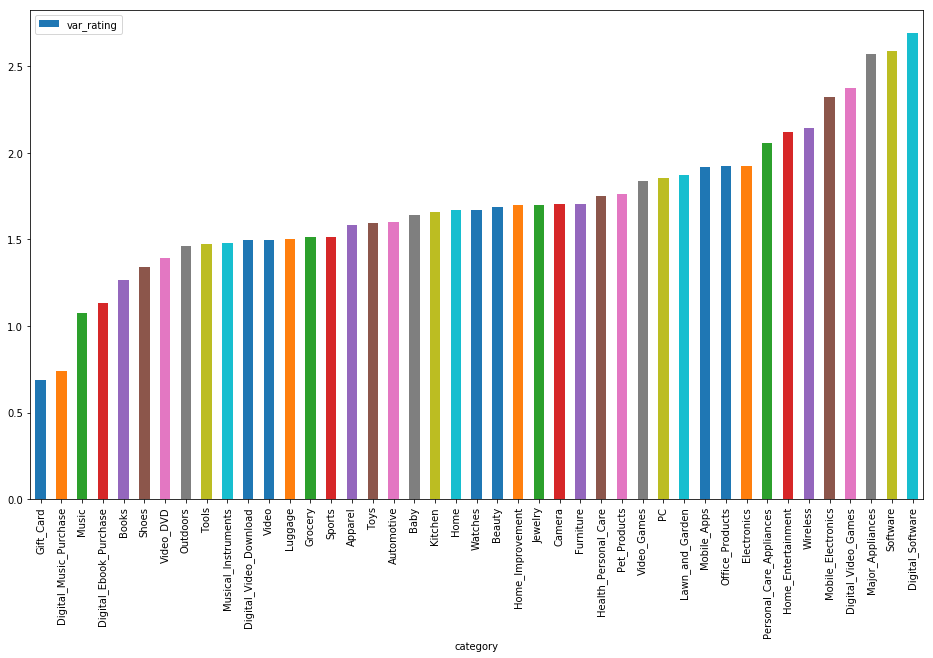

In [18]:
#Variance of raiting within category

def var_rating(category):
    """
    Return variance of raiting within category
    """
    return read_DataFrame(category).star_rating.var()

reviews['var_rating'] = reviews['category'].apply(var_rating)
reviews.sort_values('var_rating').plot.bar(x='category', y='var_rating', figsize=(16,9))

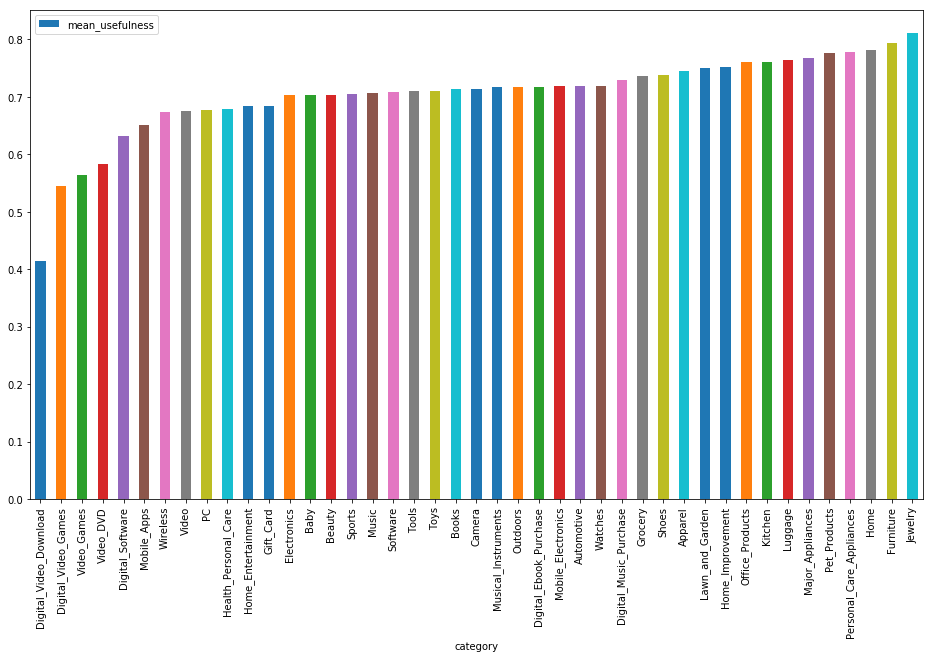

In [19]:
# Mean usefulness score of a category
def mean_usefulness(category):
    """
    Return mean helpful rate of a category
    """
    df = read_DataFrame(category)
    return np.mean(df.helpful_votes / df.total_votes)

reviews['mean_usefulness'] = reviews['category'].apply(mean_usefulness)
reviews.sort_values('mean_usefulness').plot.bar(x='category', y='mean_usefulness', figsize=(16,9))

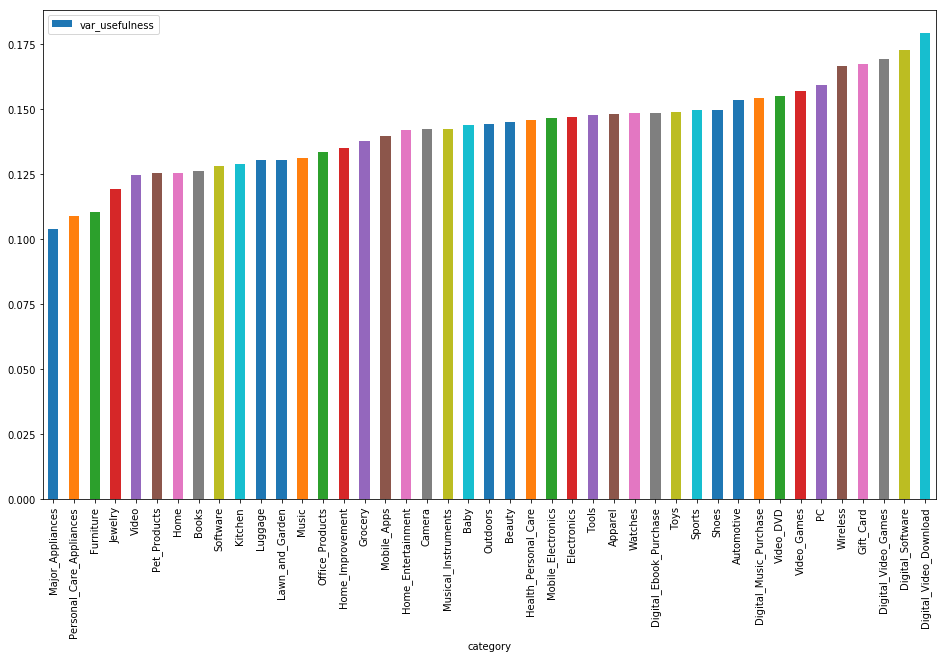

In [20]:
def var_usefulness(category):
    """
    Variance of helpful rate of a category
    """
    df = read_DataFrame(category)
    return np.var(df.helpful_votes / df.total_votes)

reviews['var_usefulness'] = reviews['category'].apply(var_usefulness)
reviews.sort_values('var_usefulness').plot.bar(x='category', y='var_usefulness', figsize=(16,9))

In [21]:
reviews.head()

,category,review_count,product_count,reviews_per_product,mean_rating,var_rating,mean_usefulness,var_usefulness
0,Shoes,4366761,551635,7.916033,4.241256,1.339806,0.738165,0.149615
1,Mobile_Apps,5033305,127061,39.613296,3.981599,1.917181,0.651378,0.139600
2,Personal_Care_Appliances,85978,15919,5.400967,3.977401,2.053911,0.777162,0.108649
3,Home_Improvement,2634428,303796,8.671701,4.182400,1.696582,0.751364,0.134908
4,Digital_Video_Download,4056597,69281,58.552807,4.201211,1.496933,0.414669,0.179085


## Temporal analysis

In [22]:
chosen_categories = ['Books', 'Wireless', 'PC', 'Home', 'Toys', 'Mobile_Apps']

In [23]:
def temporal_analysis(chosen_categories, method):
    df = pd.DataFrame()
    for category in chosen_categories:
        method(category, df)
    return df

In [24]:
def plot_temporal_evolution(chosen_categories, df):
    df.plot(y=chosen_categories, figsize=(16,10))

### Number of reviews by year

In [25]:
def count_reviews_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).size()

In [26]:
df_years = temporal_analysis(chosen_categories, count_reviews_by_year)
df_years

,Books,Wireless,PC,Home,Toys,Mobile_Apps
review_date,,,,,,
1995,198,NaN,NaN,NaN,NaN,NaN
1996,4670,NaN,NaN,NaN,NaN,NaN
1997,36610,NaN,NaN,NaN,1.0,NaN
1998,120851,2.0,NaN,5.0,40.0,NaN
1999,244559,102.0,384.0,7.0,1974.0,NaN
2000,540476,581.0,3596.0,165.0,3278.0,NaN
2001,444904,1633.0,6588.0,738.0,6184.0,NaN
2002,426895,1413.0,10125.0,2075.0,12676.0,NaN
2003,440007,2562.0,13630.0,5800.0,19165.0,NaN


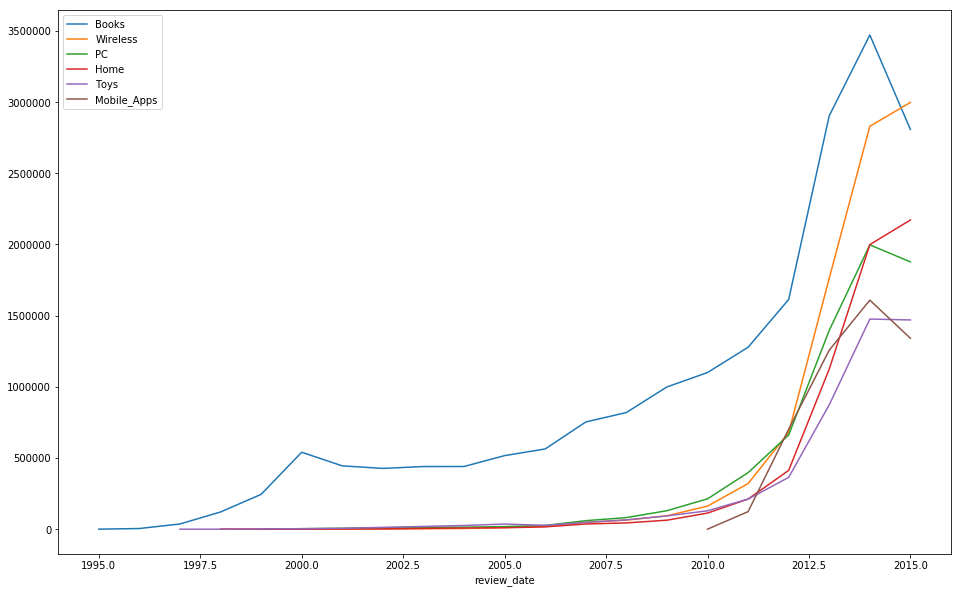

In [27]:
plot_temporal_evolution(chosen_categories, df_years)

### Number of products reviewed by year

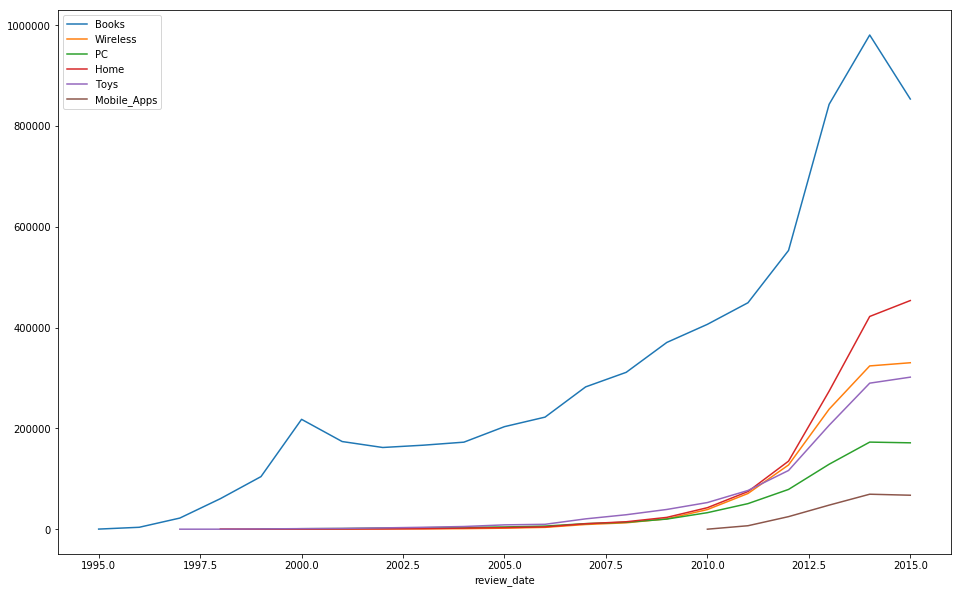

In [28]:
def count_products_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).product_parent.nunique()
    
products_years = temporal_analysis(chosen_categories, count_products_by_year)
plot_temporal_evolution(chosen_categories, products_years)

### Average rating per year

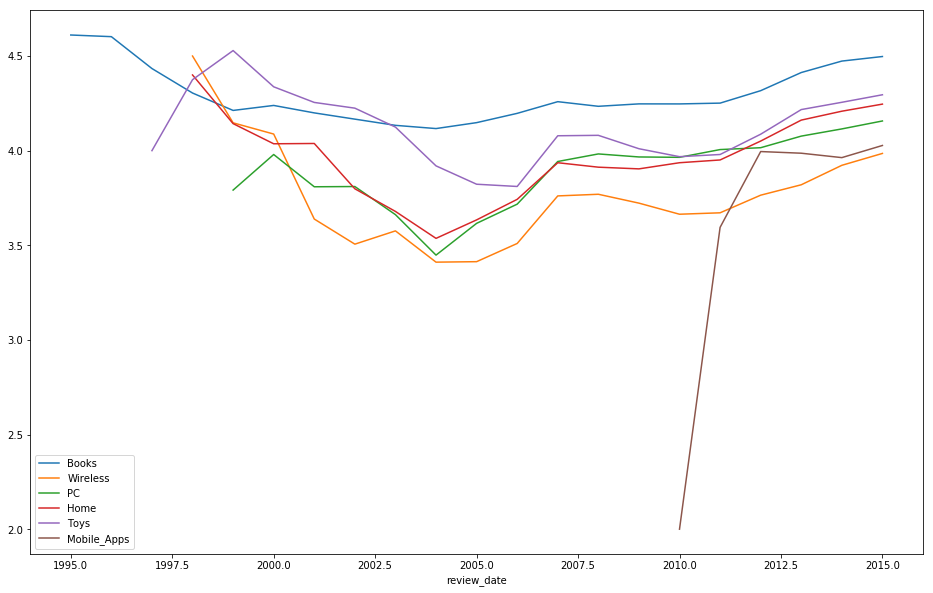

In [29]:
def rating_by_year(category, df):
    df_read = read_DataFrame(category)
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).star_rating.mean()
    
rating_years = temporal_analysis(chosen_categories, rating_by_year)
plot_temporal_evolution(chosen_categories, rating_years)

### Usefullness by year

In [30]:
def usefulness_by_year(category, df):
    df_read = read_DataFrame(category)
    df_read['usefulness'] = df_read.helpful_votes / df_read.total_votes
    df[category] = df_read.groupby(pd.DatetimeIndex(df_read['review_date']).year).usefulness.mean()
    
usefulness_years = temporal_analysis(chosen_categories, usefulness_by_year)


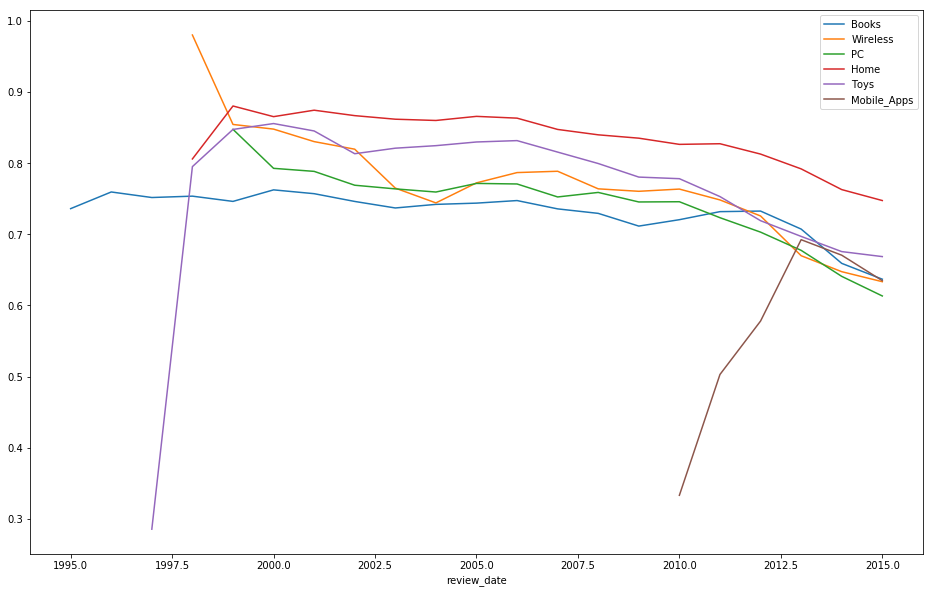

In [31]:
plot_temporal_evolution(chosen_categories, usefulness_years)

Are there more reviews but of lower quality?

## Analysis of books reviews

### Are helpful reviews related to star ratings?

In [32]:
df_books = read_DataFrame('Books')
df_books["helpful_rate"] = df_books["helpful_votes"] / df_books["total_votes"]
df_books.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date,helpful_rate
0,25933450,RJOVP071AVAJO,84656342,Books,5,0,0,2015-08-31,NaN
1,1801372,R1ORGBETCDW3AI,729938122,Books,5,0,0,2015-08-31,NaN
2,5782091,R7TNRFQAOUTX5,678139048,Books,5,0,0,2015-08-31,NaN
3,32715830,R2GANXKDIFZ6OI,712432151,Books,5,0,0,2015-08-31,NaN
4,14005703,R2NYB6C3R8LVN6,800572372,Books,5,2,2,2015-08-31,1.0


In [33]:
# keep only review with books_reviews with more than 5 votes
df_books_5 = df_books[df_books["total_votes"] > 5]
df_books_5.count()

customer_id         3992312
review_id           3992312
product_parent      3992312
product_category    3992312
star_rating         3992312
helpful_votes       3992312
total_votes         3992312
review_date         3992312
helpful_rate        3992312
dtype: int64

In [34]:
# groupby customer_id and filter to keep only customer with more than 5 reviews
df_books_5_5 = df_books_5.groupby("customer_id").filter(lambda r: len(r) > 5)

df_books_5_5.head()

,customer_id,review_id,product_parent,product_category,star_rating,helpful_votes,total_votes,review_date,helpful_rate
348,47904504,R2T328JHHK1NT0,3731425,Books,5,5,7,2015-08-31,0.714286
396,13129675,RH3DZDJG7350O,888190146,Books,4,12,13,2015-08-31,0.923077
438,52254797,RU9QBKQKRKNLK,953844844,Books,5,7,8,2015-08-31,0.875000
482,33356949,R32XJ7SV9MYTZN,906441903,Books,4,16,17,2015-08-31,0.941176
600,52413873,R25LRAO8Z4UGZO,592531765,Books,5,9,9,2015-08-31,1.000000


Correlation between helpful review and star rating:  0.5704854834055942


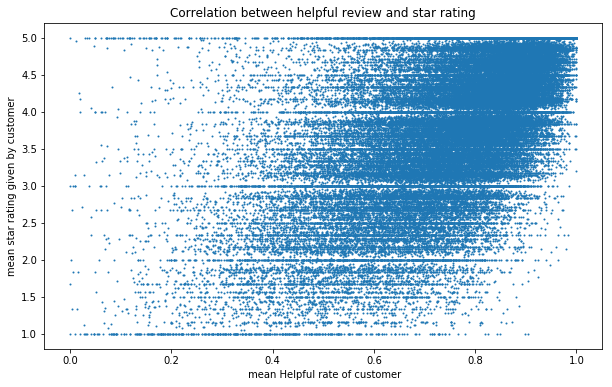

In [36]:
# mhr = mean helpful rate
mhr_by_customer = df_books_5_5.groupby("customer_id")["helpful_rate"].aggregate(np.mean)

# msr = mean star rating
msr_by_customer = df_books_5_5.groupby("customer_id")["star_rating"].aggregate(np.mean)

plt.figure(figsize=(10, 6))
plt.scatter(mhr_by_customer, msr_by_customer, s=1)
plt.xlabel(" mean Helpful rate of customer")
plt.ylabel("mean star rating given by customer")
plt.title("Correlation between helpful review and star rating")
print("Correlation between helpful review and star rating: ",np.corrcoef(mhr_by_customer, msr_by_customer)[0][1])

So, people are more likely to find a review helpful if the star rating corresponding is high. This could indicate a sort of bias or snowball effect.

### Does high rating influence the usefulness score of review?

Idea: do an observation study. For customers with at least 5 reviews and products with at least 5 reviews. We suppose that a customer writes reviews of comparable quality, regardless of score which he gives. (We could even do better and consider reviews that have a sufficient length.) Then, for each customer we count how many pairs of reviews fall in the categories: 1. reviews have equal star ratings and equal helpful rate, 2. reviews have different star rates and equal helpful rate, 3. review A has better star rating and better helpful rate, 4. review A has better star rate but worse helpful rate. We aggregate these over all reviewers and interprete the results. If category 3 is significantly greater than 4 we can say that the star rating influence positively how helpful the review seems to us (which is bad).

## Analysis of text reviews

Consider downloading a K-core subset of a desired category from here: [Source](http://jmcauley.ucsd.edu/data/amazon/)

I also extracted data manually but these are too big files to upload to my gdrive. You can ask me for a specific subset


## Statistical analysis of vary bad reviews

In [37]:
df_books_ref = df_books[(df_books['total_votes'] > 4)]

Let's choose reviews that have at least 5 votes an 0.0 helpful rate.

In [38]:
bad_df_books = df_books[(df_books['helpful_rate'] == 0.0) & (df_books['total_votes'] > 4)]
bad_df_books.count()

customer_id         111623
review_id           111623
product_parent      111623
product_category    111623
star_rating         111623
helpful_votes       111623
total_votes         111623
review_date         111623
helpful_rate        111623
dtype: int64

Let's compare the basic statistics of "bad reviews" and all the reviews in books category.

In [39]:
bad_df_books['star_rating'].describe()

count    111623.000000
mean          3.039508
std           1.598772
min           1.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           5.000000
Name: star_rating, dtype: float64

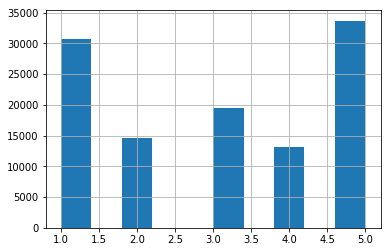

In [40]:
bad_df_books['star_rating'].hist()

In [41]:
df_books_ref['star_rating'].describe()

count    4.666782e+06
mean     3.833251e+00
std      1.489634e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: star_rating, dtype: float64

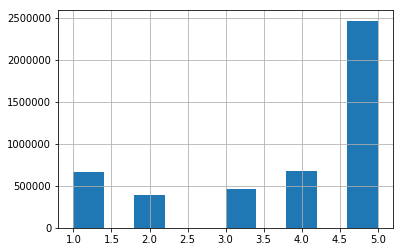

In [42]:
df_books_ref['star_rating'].hist()

There are a lot of negative ratings in bad reviews. Other scores also appear, though. Considering all the reviews, the 5 star ratings are most common.

In [43]:
#Number of reviews per customer
bad_df_books['customer_id'].count()/ bad_df_books['customer_id'].nunique()

1.0893130739428716

In [44]:
#Number of reviews per customer
df_books_ref['customer_id'].count()/ df_books_ref['customer_id'].nunique()

1.9522821056013493

On average, only one bad review is written per customer, while two "regular" reviews per customer.

In [45]:
bad_df_books.groupby('customer_id').size().describe()

count    102471.000000
mean          1.089313
std           0.888277
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         140.000000
dtype: float64

In [46]:
df_books_ref.groupby('customer_id').size().describe()

count    2.390424e+06
mean     1.952282e+00
std      1.774935e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.004800e+04
dtype: float64

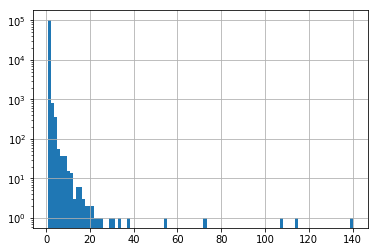

In [47]:
fig, ax = plt.subplots()
bad_df_books.groupby('customer_id').size().hist(ax=ax, bins=100)
ax.set_yscale('log')


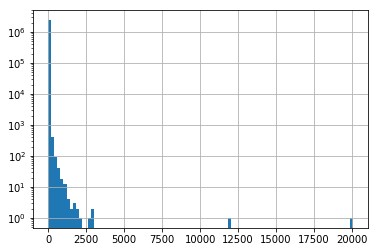

In [48]:
fig, ax = plt.subplots()
df_books_ref.groupby('customer_id').size().hist(ax=ax, bins=100)
ax.set_yscale('log')

There are only a few customers that produce a lot of really bad reviews. The outliers can represent "fake reviews" and "fake reviewers". In the plot of reference book reviews there are also strong outliers. It seems unlikely that a person can write 20000 genuine reviews. Let's check if this is the "bad guy".

In [59]:
bad_guys = bad_df_books.groupby('customer_id').filter(lambda x: len(x)> 100)['customer_id'].unique()
bad_guys

array([35985708, 50122160, 43530996])

In [61]:
df_books_ref.groupby('customer_id').filter(lambda x: len(x)> 2500)['customer_id'].unique()

array([50732546, 36642996, 50776149, 52615377, 50122160])

So we caught one bad guy! 50122160

### Fake reviews ? 

Classifier(DBSCAN) based on Usefulness of review(DONE), length of review, Deviation from average rating,
Sentiment Analysis, (user-based: Number of total reviews from reviewer, average review length of reviewer, frequency of length of review, ratio of extreme rating(5 or 0) given by reviewer, average Deviation from all of his reviews)

In [448]:
category = "PC"
df_pc_txt = spark.read.parquet(TXT_PARQUET_DIR + category + '_text.parquet.gzip/part-00000-9ba038bf-8d13-47b6-879d-9b380b00a182-c000.gz.parquet')
df_pc = spark.read.parquet(PARQUET_DIR + category + ".parquet.gzip") # have to remove SUCCESS.crc from directory 

In [449]:
#Fused with 2 other chosen categories.

cat2 = "Wireless"
cat3 = "Automotive"

df_wire_txt = spark.read.parquet(TXT_PARQUET_DIR + cat2 + '_text.parquet.gzip/part-00000-321618fb-c8f4-49c2-a9bb-a4afbf170e56-c000.gz.parquet')
df_wire = spark.read.parquet(PARQUET_DIR + cat2 + ".parquet.gzip")
df_auto_txt = spark.read.parquet(TXT_PARQUET_DIR + cat3 + '_text.parquet.gzip/part-00000-9b5fa30a-3f70-45ca-b030-c1719f5fd7db-c000.gz.parquet')
df_auto = spark.read.parquet(PARQUET_DIR + cat3 + ".parquet.gzip")

df_fused_txt = df_pc_txt.union(df_wire_txt).union(df_auto_txt)
df_fused = df_pc.union(df_wire).union(df_auto)

In [450]:
afinn = Afinn()
sentiment_analysis = udf(lambda text: afinn.score(text), DoubleType())

#important to execute it in first. Keep only reviews with more than 5 votes
# and reviews from reviewers with more than 5 reviews.
def filtering(df):
    
    df = df.filter("total_votes > 5")
    df_plus = df.groupby("customer_id").agg(count(lit(1)).alias("R_tot_reviews"))
    df_joined = df.join(df_plus, "customer_id")
                                        
    return df_joined.filter("R_tot_reviews > 5")

# Add multiple features // length of reviews and usefulness of reviews
def optimized0(df):
    
    df_1 = df.withColumn("len_rev", length(df.review_body))
    return df_1.withColumn("usefulness", (df.helpful_votes / df.total_votes))

# Add deviation to average of rating for the same product.
def deviation_avg_rating(df):

    df_avg = df.groupBy("product_parent").agg(mean("star_rating").alias("avg_rating"))
    df_joined = df.join(df_avg, "product_parent")
    df_joined_avg = df_joined.withColumn("dev_avg_rating", (df_joined.star_rating - df_joined.avg_rating))
    
    return df_joined_avg.drop("avg_rating")

# Add multiple features // Reviewer average length of review, reviewer mean rating, reviewer average deviation rating,
# reviewer ratio of maximal and minimal rating.
def optimized1(df):
    cnt_cond = lambda cond: sum(when(cond, 1).otherwise(0))
    df_filter = df.groupby("customer_id").agg(mean("len_rev").alias("R_avg_len_rev"),
                                              mean("star_rating").alias("R_mean_rating"),
                                              mean("dev_avg_rating").alias("R_avg_dev"),
                                             cnt_cond(col("star_rating") == 5).alias("five_star"),
                                             cnt_cond(col("star_rating") == 1).alias("zero_star"))
    
    df_joined = df.join(df_filter, "customer_id")
    df_joined = df_joined.withColumn("five_rate", (df_joined.five_star / df_joined.R_tot_reviews))
    df_joined = df_joined.withColumn("zero_rate", (df_joined.zero_star / df_joined.R_tot_reviews))

    return df_joined.drop("five_star","zero_star")

# Add reviewer frequency of review's length
def R_freq_len_rev(df):
    
    df_filter = df.groupBy("customer_id","len_rev").agg(count(lit(1)).alias("R_len_freq"))
    df_filter = df_filter.withColumnRenamed("len_rev", "len_rev_drop").withColumnRenamed("customer_id", "cust_id_drop")
    df_joined = df.join(df_filter, (df.customer_id == df_filter.cust_id_drop) & (df.len_rev == df_filter.len_rev_drop))
    
    return df_joined.drop("len_rev_drop", "cust_id_drop")

# Add sentiment analysis score of review body --> positive sentiment = positive score and vice versa
def add_afinn(df):
     return df.withColumn("afinn", sentiment_analysis(df.review_body))

In [452]:
# Compute the functions to add all features needed for classifier.
df_fused_5 = filtering(df_fused)
df_fused_5 = deviation_avg_rating(df_fused_5)
df_all = df_fused_5.join(df_fused_txt, "review_id")
df_all = optimized0(df_all)
df_all = optimized1(df_all)
df_all = R_freq_len_rev(df_all)
df_all = add_afinn(df_all)

In [387]:
# Keep only the features we need for classifier
df_tr = df_all["customer_id","star_rating","R_tot_reviews","R_mean_rating",
                  "len_rev","R_len_freq","R_avg_len_rev","usefulness","dev_avg_rating",
                  "five_rate","zero_rate","R_avg_dev","afinn"]

In [388]:
# Convert to pandas Dataframe, Computational Time : ~ 4 min 26 sec
x_tr = df_tr.toPandas()

In [389]:
x_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59947 entries, 0 to 59946
Data columns (total 13 columns):
customer_id       59947 non-null int32
star_rating       59947 non-null int32
R_tot_reviews     59947 non-null int64
R_mean_rating     59947 non-null float64
len_rev           59947 non-null int32
R_len_freq        59947 non-null int64
R_avg_len_rev     59947 non-null float64
usefulness        59947 non-null float64
dev_avg_rating    59947 non-null float64
five_rate         59947 non-null float64
zero_rate         59947 non-null float64
R_avg_dev         59947 non-null float64
afinn             59947 non-null float64
dtypes: float64(8), int32(3), int64(2)
memory usage: 5.3 MB


### Classifier

In [512]:
from sklearn.cluster import DBSCAN
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

In [526]:
#K_mean only cluster different length of review
db = DBSCAN(eps=0.5, min_samples=5)
ss = StandardScaler()

In [527]:
ID = x_tr["customer_id"]          
x_tr = x_tr.drop("customer_id", axis=1)

In [528]:
# Standaridzation of the data and shuffle
scaled = ss.fit_transform(x_tr)
scaled = shuffle(scaled)

/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [529]:
# Trick to reduce by 2 the memory usage (convert float64 to float32 as we don't need more than 6 decimals)
pd_scaled = pd.DataFrame(scaled)
pd_scaled = pd_scaled.apply(pd.to_numeric, downcast="float")
pd_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59947 entries, 0 to 59946
Data columns (total 13 columns):
0     59947 non-null float32
1     59947 non-null float32
2     59947 non-null float32
3     59947 non-null float32
4     59947 non-null float32
5     59947 non-null float32
6     59947 non-null float32
7     59947 non-null float32
8     59947 non-null float32
9     59947 non-null float32
10    59947 non-null float32
11    59947 non-null float32
12    59947 non-null float32
dtypes: float32(13)
memory usage: 3.0 MB


In [530]:
x_tr["fake"] = db.fit_predict(scaled)

(array([57035.,   664.,   485.,   479.,   267.,   255.,   220.,   205.,
          174.,   163.]),
 array([ -1. ,  31.8,  64.6,  97.4, 130.2, 163. , 195.8, 228.6, 261.4,
        294.2, 327. ]),
 <a list of 10 Patch objects>)

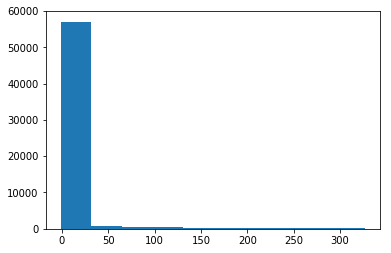

In [531]:
plt.hist(x_tr["fake"])

In [532]:
x_tr["customer_id"] = ID

In [533]:
len(x_tr[x_tr["fake"] == -1])

44495

In [534]:
x_tr[x_tr["fake"] == 0]

,star_rating,R_tot_reviews,R_mean_rating,len_rev,R_len_freq,R_avg_len_rev,usefulness,dev_avg_rating,five_rate,zero_rate,R_avg_dev,afinn,fake,customer_id
1,3,26,3.538462,305,1,369.653846,0.000000,-1.000000,0.076923,0.000000,-0.169139,6.0,0,5478843
3,5,40,4.875000,817,1,654.300000,0.800000,0.250000,0.950000,0.025000,0.050000,31.0,0,9295389
12,4,45,4.333333,931,2,4927.777778,0.875000,0.000000,0.488889,0.000000,-0.058915,26.0,0,11876489
16,5,9,4.666667,299,1,571.222222,0.833333,0.000000,0.888889,0.000000,0.246914,-2.0,0,12122942
21,5,6,4.166667,5910,1,1769.000000,0.818182,1.500000,0.666667,0.166667,0.250000,85.0,0,13031406
22,5,12,4.833333,1330,1,2209.416667,0.890756,0.333333,0.833333,0.000000,0.808796,14.0,0,13066422
28,3,21,3.857143,279,1,1638.619048,0.444444,0.000000,0.428571,0.047619,0.152778,0.0,0,13976662
33,4,41,4.731707,4552,1,9292.560976,0.875000,0.333333,0.780488,0.000000,0.279836,87.0,0,14886812
41,1,6,1.000000,859,6,859.000000,0.916667,0.000000,0.000000,1.000000,-0.166667,-1.0,0,16344446
44,1,6,1.000000,859,6,859.000000,0.833333,0.000000,0.000000,1.000000,-0.166667,-1.0,0,16344446


In [535]:
# faker type 1 copy paste review text and 100% rating of 1
x_tr[x_tr["customer_id"] == 49975770]

,star_rating,R_tot_reviews,R_mean_rating,len_rev,R_len_freq,R_avg_len_rev,usefulness,dev_avg_rating,five_rate,zero_rate,R_avg_dev,afinn,fake,customer_id
8680,1,17,1.0,513,12,511.529412,0.636364,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8681,1,17,1.0,513,12,511.529412,0.428571,-2.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8682,1,17,1.0,513,12,511.529412,0.500000,0.000000,0.0,1.0,-0.539216,6.0,107,49975770
8683,1,17,1.0,513,12,511.529412,0.421053,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8684,1,17,1.0,513,12,511.529412,0.764706,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8685,1,17,1.0,513,12,511.529412,0.250000,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8686,1,17,1.0,513,12,511.529412,0.416667,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8687,1,17,1.0,513,12,511.529412,0.666667,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8688,1,17,1.0,513,12,511.529412,0.444444,0.000000,0.0,1.0,-0.539216,6.0,-1,49975770
8689,1,17,1.0,513,12,511.529412,0.400000,-2.666667,0.0,1.0,-0.539216,6.0,-1,49975770


In [536]:
# faker type 2 100% rating of 5 but varying a bit text of review
x_tr[x_tr["customer_id"] == 21864605]

,star_rating,R_tot_reviews,R_mean_rating,len_rev,R_len_freq,R_avg_len_rev,usefulness,dev_avg_rating,five_rate,zero_rate,R_avg_dev,afinn,fake,customer_id
4620,5,13,5.0,393,1,272.538462,0.714286,0.000000,1.0,0.0,0.358974,6.0,-1,21864605
23097,5,13,5.0,143,3,272.538462,0.375000,0.000000,1.0,0.0,0.358974,3.0,-1,21864605
23098,5,13,5.0,143,3,272.538462,0.428571,0.000000,1.0,0.0,0.358974,3.0,-1,21864605
23099,5,13,5.0,143,3,272.538462,0.400000,0.000000,1.0,0.0,0.358974,3.0,52,21864605
30232,5,13,5.0,391,1,272.538462,0.538462,0.000000,1.0,0.0,0.358974,6.0,-1,21864605
32887,5,13,5.0,453,1,272.538462,0.533333,0.000000,1.0,0.0,0.358974,3.0,-1,21864605
37109,5,13,5.0,257,1,272.538462,0.120000,0.000000,1.0,0.0,0.358974,6.0,-1,21864605
42142,5,13,5.0,214,1,272.538462,0.826087,2.666667,1.0,0.0,0.358974,0.0,-1,21864605
45756,5,13,5.0,154,1,272.538462,0.400000,0.000000,1.0,0.0,0.358974,13.0,-1,21864605
47205,5,13,5.0,354,3,272.538462,0.523810,0.000000,1.0,0.0,0.358974,6.0,-1,21864605


In [537]:
# Really not happy reviewer maybe faker ? check text 
x_tr[x_tr["customer_id"] == 37768226]

,star_rating,R_tot_reviews,R_mean_rating,len_rev,R_len_freq,R_avg_len_rev,usefulness,dev_avg_rating,five_rate,zero_rate,R_avg_dev,afinn,fake,customer_id
3386,3,39,1.923077,2680,1,3605.769231,0.800000,0.0,0.0,0.358974,0.051282,-23.0,-1,37768226
5625,2,39,1.923077,2962,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-34.0,0,37768226
6224,2,39,1.923077,2725,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-37.0,-1,37768226
6795,3,39,1.923077,3078,1,3605.769231,0.960000,0.0,0.0,0.358974,0.051282,-36.0,-1,37768226
7098,2,39,1.923077,3150,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-37.0,-1,37768226
9473,2,39,1.923077,2192,1,3605.769231,0.555556,0.0,0.0,0.358974,0.051282,-25.0,-1,37768226
12994,4,39,1.923077,3129,1,3605.769231,0.500000,1.5,0.0,0.358974,0.051282,-31.0,-1,37768226
14284,2,39,1.923077,3540,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-45.0,0,37768226
15895,1,39,1.923077,2554,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-25.0,-1,37768226
17340,2,39,1.923077,4766,1,3605.769231,1.000000,0.0,0.0,0.358974,0.051282,-46.0,157,37768226


In [538]:
x_tr["fake"].drop_duplicates()

0         -1
1          0
4          1
6          2
9          3
17       170
30         4
35         5
56        51
62        15
72         6
81       104
103      230
124        7
154        8
171        9
173      285
182      245
193       59
194       10
220       11
271      110
283       75
324       12
331       13
355      109
422       14
472       16
498       17
507       18
        ... 
17102    281
17991    257
18005    265
18140    223
18268    237
18385    324
18388    243
18554    255
18747    213
18753    214
18976    300
19430    313
19837    318
20115    305
20119    219
21367    296
23659    272
23731    266
24629    244
24692    315
25286    320
25588    247
26141    290
29925    286
32010    271
33233    275
38671    308
38999    287
43306    309
45829    299
Name: fake, Length: 329, dtype: int64

## try semi-supervised

In [539]:
x_semi = x_tr.drop("fake", axis= 1)

In [577]:
#check 20 biggest reviewers
x_20 = x_semi.groupby("customer_id").count().sort_values("R_tot_reviews", ascending=False)[:20].reset_index(drop=False)

In [588]:
semi2 = x_semi[x_semi.customer_id.isin(x_20.customer_id)].copy()

In [595]:
semi2["label"] = 0
semi2.label[semi2["customer_id"] == 15886030] = 1
semi2.label[semi2["customer_id"] == 45070473] = 1

30208851
34633160
52340667
51712970
53090839
53037408

53080186
32038204
52859210
52938899

/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [605]:
pd.set_option('display.max_rows', 5000)
semi2.sort_values("len_rev")

,star_rating,R_tot_reviews,R_mean_rating,len_rev,R_len_freq,R_avg_len_rev,usefulness,dev_avg_rating,five_rate,zero_rate,R_avg_dev,afinn,customer_id,label
48648,1,177,3.525424,52,1,1694.819209,0.333333,0.000000,0.418079,0.197740,-0.142072,2.0,52340667,0
43224,5,177,3.525424,83,1,1694.819209,0.042857,0.500000,0.418079,0.197740,-0.142072,4.0,52340667,0
48147,5,183,4.923497,116,1,1354.836066,0.625000,0.000000,0.934426,0.000000,0.125268,0.0,30208851,0
2368,1,177,3.525424,147,1,1694.819209,0.042254,0.000000,0.418079,0.197740,-0.142072,4.0,52340667,0
31171,5,197,4.868020,158,1,7036.380711,1.000000,0.000000,0.878173,0.000000,0.381994,8.0,45070473,1
21939,5,115,4.095652,171,1,6927.930435,0.871795,0.000000,0.365217,0.017391,-0.031366,3.0,50273418,0
45330,4,177,3.525424,171,1,1694.819209,0.857143,0.000000,0.418079,0.197740,-0.142072,1.0,52340667,0
30523,5,183,4.923497,188,1,1354.836066,0.788991,0.000000,0.934426,0.000000,0.125268,6.0,30208851,0
35069,5,183,4.923497,189,12,1354.836066,0.782609,0.000000,0.934426,0.000000,0.125268,6.0,30208851,0
35068,5,183,4.923497,189,12,1354.836066,0.857143,0.000000,0.934426,0.000000,0.125268,6.0,30208851,0


In [609]:
df_all.filter("customer_id == 30208851 AND len_rev == 1566").select("review_body").show(truncate =False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------